In [1]:
# uncomment the following if you had not installed the package
# import sys
# sys.path.append('/home/khan/Documents/developments/pyIntertidalDEM')

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import xarray as xr
import cartopy.crs as ccrs

from pyintdem.shorelines import Shorelines

# Loading the shorelines

In [2]:
fdir = Path('D:\Sentinel2\Shorelines')
shorelines = Shorelines(fdir, pattern='*/shoreline*.csv')
shorelines

[WindowsPath('D:/Sentinel2/Shorelines/T38JLT/20161218072205/shoreline_0.5_3.0.csv'),
 WindowsPath('D:/Sentinel2/Shorelines/T38JLT/20161228072205/shoreline_0.5_3.0.csv'),
 WindowsPath('D:/Sentinel2/Shorelines/T38JLT/20170124071548/shoreline_0.5_3.0.csv'),
 WindowsPath('D:/Sentinel2/Shorelines/T38JLT/20170203071245/shoreline_0.5_3.0.csv'),
 WindowsPath('D:/Sentinel2/Shorelines/T38JLT/20170206072352/shoreline_0.5_3.0.csv'),
 WindowsPath('D:/Sentinel2/Shorelines/T38JLT/20231224071209/shoreline_0.5_3.0.csv'),
 WindowsPath('D:/Sentinel2/Shorelines/T38JMS/20170114071511/shoreline_0.5_3.0.csv'),
 WindowsPath('D:/Sentinel2/Shorelines/T38JMS/20170124071548/shoreline_0.5_3.0.csv'),
 WindowsPath('D:/Sentinel2/Shorelines/T38JMS/20170223071209/shoreline_0.5_3.0.csv'),
 WindowsPath('D:/Sentinel2/Shorelines/T38JMS/20170305071617/shoreline_0.5_3.0.csv'),
 WindowsPath('D:/Sentinel2/Shorelines/T38JMS/20170504071503/shoreline_0.5_3.0.csv'),
 WindowsPath('D:/Sentinel2/Shorelines/T38JMS/20231214071209/shore

In [7]:
# If you do not want to reference, just want combined shorelines
fpath_shoreline = Path('D:\Sentinel2\shorelines.csv')
shorelines.combine(fname=fpath_shoreline, elev=False)

,lon,lat
0,43.408486,-24.688719
1,43.378429,-24.811734
2,43.353285,-24.917638
3,43.309537,-25.104852
4,43.290141,-25.187509
...,...,...
31668140,50.239327,-14.559795
31668141,50.239513,-14.559795
31668142,50.254736,-14.559844
31668143,50.255664,-14.559847


# Generating water levels

- Can be of any source, model, observation, altimetry
- Here reconstructed from FES2014 using pycaz package (https://github.com/jamal919/pycaz)

In [ ]:
# Creating waterlevel using pycaz/utide module
# Loading and cropping atlas
sys.path.append('/home/khan/Documents/developments/jamal919/pycaz')
from pycaz.tide.atlas import read_atlas
from pycaz.tide.utide import reconstruct_waterlevel

atlas_dir = '/run/media/khan/Workbench/Developments/Tide_Atlas/data/FES2014/fes2014b_elevation'
fes2014 = read_atlas(atlas_dir, lon180=False)

x = fes2014.lon[np.logical_and(fes2014.lon>= extent[0], fes2014.lon<=extent[1])]
y = fes2014.lat[np.logical_and(fes2014.lat>= extent[2], fes2014.lat<=extent[3])]

atlas_dir = '/run/media/khan/Workbench/Developments/Tide_Atlas/data/FES2014/fes2014b_elevation'
fes2014 = read_atlas(atlas_dir, lon180=False)
fes2014_over_image = fes2014.interp(method='linear', lon=x, lat=y)

fname = '/run/media/khan/Workbench/Developments/Bengal/waterlevels.nc'
timestamps = shorelines.timestamps(buffer='1H') # Adding additional timesteps to have buffer
ds = reconstruct_waterlevel(fname=fname, atlas=fes2014_over_image, timestamps=timestamps)
ds.close()

# Applying vertical height to shorelines

In [ ]:
fname = '/run/media/khan/Workbench/Developments/Bengal/waterlevels.nc'
ds = xr.open_dataset(fname)

In [45]:
# If you want to reference and then combine
demfile = '/run/media/khan/Workbench/Developments/Bengal/dem.csv'
shorelines.reference(ds=ds) # ds is the corresponding water level to combine
dem = shorelines.combine(fname=demfile)

In [47]:
# Shape after removing overlapping
dem.loc[:, 'pair'] = dem.apply(lambda x: f'{x.lon}-{x.lat}', axis=1)
dem = dem.groupby(dem.pair).min()
dem = dem.reset_index().drop(columns=['pair'])
dem.shape

(991482, 3)

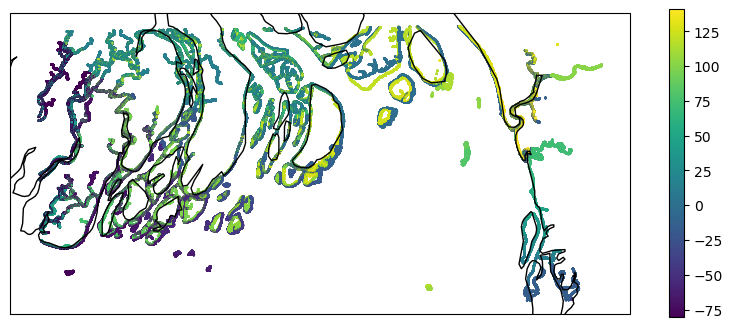

In [48]:
fig, ax = plt.subplots(figsize=(10, 4), subplot_kw={'projection':ccrs.PlateCarree()})
sc = ax.scatter(dem.lon, dem.lat, c=dem.elev, s=0.5, cmap='viridis')
ax.coastlines()
plt.colorbar(sc)